# Sprint
## 機械学習フロー
丁寧な検証が行える状態にした上で、他者の解法を参考に汎化性能の高いモデル作りを進めます。

# 【問題1】
## クロスバリデーション
事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。

事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# データセット読み込み
credits_train = pd.read_csv('application_train.csv')
credits_test = pd.read_csv('application_test.csv')

In [3]:
X = credits_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].values
y = credits_train['TARGET']

In [4]:
def scale_and_fill(X, scaler):
    # 標準化
    X_norm = scaler.transform(X)

    # 欠損値確認
    nan_num = np.isnan(X_norm).sum()

    # 穴埋め用乱数生成 - arr_replace
    rands = np.random.normal(0, 1, nan_num)
    arr_replace = np.zeros(X_norm.shape)
    np.place(arr_replace, np.isnan(X_norm), rands)

    # 欠損値穴埋め
    X_norm_filled = np.where(np.isnan(X_norm), arr_replace, X_norm)
    return X_norm_filled

In [10]:
# KFold検証
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

kf = KFold(n_splits=5)
scaler = StandardScaler()
rforest = RandomForestClassifier()
print(f'split: {kf.get_n_splits(X)}')
auc_arr = np.zeros(kf.get_n_splits(X))

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # スケーリングとか
    scaler.fit(X_train)
    X_train_new = scale_and_fill(X_train, scaler)
    # 学習・予測
    rforest.fit(X_train_new, y_train)
    # バリデーション
    X_test_new = scale_and_fill(X_test, scaler)
    y_test_pred = rforest.predict_proba(X_test_new)[:, 1]
    auc_score = roc_auc_score(y_test, y_test_pred)
    auc_arr[i] = auc_score
    print(f'{i+1}. AUC - test: {auc_score}')

print(f'AUC - test/average: {np.mean(auc_arr)}')

split: 5
1. AUC - test: 0.6455288079408439
2. AUC - test: 0.6517000510935217
3. AUC - test: 0.6497391949973208
4. AUC - test: 0.6522689109152051
5. AUC - test: 0.6506231475455044
AUC - test/average: 0.6499720224984792


# 【問題2】
## グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。

scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。

[sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

In [13]:
# 最終チェック用
from sklearn.model_selection import train_test_split

X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, stratify=y)

scaler.fit(X2_train)
X2_train_new = scale_and_fill(X2_train, scaler)

In [14]:
# グリッドサーチ
from sklearn.model_selection import GridSearchCV

rforest2 = RandomForestClassifier()
params = {
    'n_estimators': [10, 50, 100, 500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1, 2, 5]
}
gscv = GridSearchCV(rforest2, param_grid=params, cv=3, verbose=1)
gscv.fit(X2_train_new, y2_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 47.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [15]:
# 最適パラメータ確認
print(f'best score: {gscv.best_score_}')
print(f'best params: {gscv.best_params_}')

best score: 0.9180602944355566
best params: {'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 500}


In [19]:
# 最適パラメータでバリデーションを行う
from sklearn.metrics import confusion_matrix

X2_test_new = scale_and_fill(X2_test, scaler)
best = gscv.best_estimator_
y2_test_pred = best.predict_proba(X2_test_new)[:, 1]

print(f'AUC: {roc_auc_score(y2_test, y2_test_pred)}')
print(best)

AUC: 0.6680807596824182
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


(array([0.00000000e+00, 1.41498755e-05, 2.82997510e-05, ...,
        9.94453249e-01, 9.94467399e-01, 1.00000000e+00]),
 array([0.        , 0.        , 0.        , ..., 0.99919433, 0.99935546,
        1.        ]),
 array([1.83198016e+00, 8.31980159e-01, 7.81988095e-01, ...,
        2.50000000e-04, 2.22222222e-04, 0.00000000e+00]))

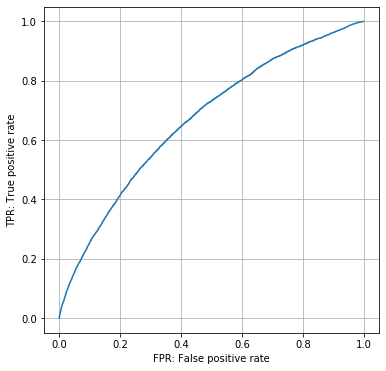

In [44]:
# プロット
from sklearn.metrics import roc_curve
roc = roc_curve(y2_test, y2_test_pred)
display(roc)

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 6)
plt.plot(roc[0], roc[1])
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

In [35]:
# testデータに対する推測を行う
def out_pred_csv(df, X, model, filename='out_pred.csv'):
    """
    信用情報分析コンペ向けcsv排出関数
    df: ID取得用DataFrame
    X: 処理済み特徴量（ID含まない） ndarray
    model: 予測モデル
    """
    ids = df['SK_ID_CURR'].values
    y_pred = model.predict_proba(X)[:, 1]
    submit_arr = np.concatenate((ids.reshape(-1, 1), y_pred.reshape(-1, 1)), axis=1)
    submit_df = pd.DataFrame(submit_arr, columns=['SK_ID_CURR', 'TARGET'])
    submit_df['SK_ID_CURR'] = submit_df['SK_ID_CURR'].astype(np.int32)
    display(submit_df)
    submit_df.info()
    submit_df.to_csv(filename, index=False)

    return True

In [31]:
X_test_submit = scale_and_fill(credits_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].values, scaler)

In [36]:
print(out_pred_csv(credits_test, X_test_submit, best, filename='sprint1-2.csv'))

,SK_ID_CURR,TARGET
0,100001,0.016143
1,100005,0.121458
2,100013,0.004667
3,100028,0.044424
4,100038,0.132554
...,...,...
48739,456221,0.054848
48740,456222,0.019690
48741,456223,0.029643
48742,456224,0.024417


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int32  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 571.3 KB
True


AUC score: **0.64998**

# 【問題3】
## Kaggle Notebooksからの調査
KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。

# 特徴量
- breau.csv（過去のローン履歴）を利用して予測する
- DAYS_BIRTH、AMT_CREDIT、AMT_ANNUITY（重要度が高い説明変数）を利用する
- ほかの説明変数との相関が高い変数を削除する
- featuretoolsを使って特徴量エンジニアリングを簡易化する
- 特徴量の総数を増やす

# モデル
- LightGBMを使う（今回は不採用）
- 層化シャッフル分割交差検証を行う（クラスが不均衡なのでStratifiedShuffleSplit?）

# 【問題4】
## 高い汎化性能のモデル作成
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。

その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。

In [52]:
# AMT_CREDIT:AMT_TOTAL_INCOMEを求める
def ratio_credit(df):
    arr_tmp = df[['AMT_CREDIT', 'AMT_INCOME_TOTAL']].values
    return np.array([arr_tmp[i, 0]/arr_tmp[i, 1] for i in range(arr_tmp.shape[0])]).reshape(-1, 1)

In [59]:
# sum(AMT_REQ_CREDIT_BUREAU_***)を求める
def sum_req(df):
    arr_tmp = df[
        [
            'AMT_REQ_CREDIT_BUREAU_HOUR',
            'AMT_REQ_CREDIT_BUREAU_DAY',
            'AMT_REQ_CREDIT_BUREAU_WEEK',
            'AMT_REQ_CREDIT_BUREAU_MON',
            'AMT_REQ_CREDIT_BUREAU_QRT',
            'AMT_REQ_CREDIT_BUREAU_YEAR'
        ]
    ].fillna(0).values
    sum_arr = np.sum(arr_tmp, axis=1)
    return np.array([sum_arr[i] for i in range(arr_tmp.shape[0])]).reshape(-1, 1)

In [74]:
# 特徴量を増やしてみる
col_list = [
    'EXT_SOURCE_1', 
    'EXT_SOURCE_2', 
    'EXT_SOURCE_3', 
    'DAYS_BIRTH', 
    'AMT_ANNUITY', 
    'DAYS_EMPLOYED'
]
X4_df = credits_train[col_list].values
display(X4_df)

array([[ 8.30369674e-02,  2.62948593e-01,  1.39375780e-01,
        -9.46100000e+03,  2.47005000e+04, -6.37000000e+02],
       [ 3.11267311e-01,  6.22245775e-01,             nan,
        -1.67650000e+04,  3.56985000e+04, -1.18800000e+03],
       [            nan,  5.55912083e-01,  7.29566691e-01,
        -1.90460000e+04,  6.75000000e+03, -2.25000000e+02],
       ...,
       [ 7.44026400e-01,  5.35721752e-01,  2.18859082e-01,
        -1.49660000e+04,  2.99790000e+04, -7.92100000e+03],
       [            nan,  5.14162820e-01,  6.61023539e-01,
        -1.19610000e+04,  2.02050000e+04, -4.78600000e+03],
       [ 7.34459669e-01,  7.08568896e-01,  1.13922396e-01,
        -1.68560000e+04,  4.91175000e+04, -1.26200000e+03]])

In [75]:
# NAME_EDUCATION_TYPEの調整を行う
edu_series = credits_train['NAME_EDUCATION_TYPE']
print(edu_series.value_counts())
print(edu_series.isnull().sum())
"""
Secondary / secondary special: 後期中等教育（9-12学年）
Higher education: 大学
Incomplete higher: 9-12学年中退？
Lower secondary: 前期中等教育
Academic degree: 学位？
おそらくlower < imcomplete < secondary < higher < academic？
"""
replace_dict = {
    "Lower secondary": 0,
    "Incomplete higher": 1,
    "Secondary / secondary special": 2,
    "Higher education": 3,
    "Academic degree": 4
}
edu_num = edu_series.replace(replace_dict).values.reshape(-1, 1)
display(edu_num)

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
0


array([[2],
       [3],
       [2],
       ...,
       [3],
       [2],
       [3]], dtype=int64)

In [80]:
# 説明変数の作成
X4 = np.concatenate((X4_df, edu_num, ratio_credit(credits_train), sum_req(credits_train)), axis=1)
display(X4)
# 分割
X4_train, X4_valid, y4_train, y4_valid = train_test_split(X4, y, stratify=y)
# スケール
scaler.fit(X4_train)
X4_train_new = scale_and_fill(X4_train, scaler)
display(X4_train_new)

array([[0.08303697, 0.26294859, 0.13937578, ..., 2.        , 2.00788889,
        1.        ],
       [0.31126731, 0.62224578,        nan, ..., 3.        , 4.79075   ,
        0.        ],
       [       nan, 0.55591208, 0.72956669, ..., 2.        , 2.        ,
        0.        ],
       ...,
       [0.7440264 , 0.53572175, 0.21885908, ..., 3.        , 4.42917647,
        3.        ],
       [       nan, 0.51416282, 0.66102354, ..., 2.        , 2.16436842,
        0.        ],
       [0.73445967, 0.7085689 , 0.1139224 , ..., 3.        , 4.28571429,
        3.        ]])

array([[-0.72869714,  1.0166243 ,  1.31151477, ..., -0.34392506,
         0.10052684, -0.06385944],
       [-0.40330759, -0.41927046, -1.98312229, ..., -0.34392506,
         0.28724008, -0.93105957],
       [ 0.97963959, -1.5092536 , -1.92443124, ..., -0.34392506,
         0.18159448, -0.06385944],
       ...,
       [-1.83638132,  0.92903987,  1.19510193, ..., -0.34392506,
        -1.02999863,  1.23694076],
       [ 0.36953715,  0.77886649,  0.58442591, ..., -0.34392506,
         0.21978578, -0.06385944],
       [ 0.02916374,  0.7991404 , -0.04984058, ..., -0.34392506,
         0.35777507, -0.06385944]])

In [83]:
from sklearn.metrics import roc_auc_score
# 学習・予測
# モデルのパラメータは{'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 500}とする
rforest2 = RandomForestClassifier(
    criterion='gini',
    min_samples_split=5,
    n_estimators=500
)
rforest2.fit(X4_train_new, y4_train)
y4_train_pred = rforest2.predict_proba(X4_train_new)[:, 1]
# AUC - train
print(f'AUC - train: {roc_auc_score(y4_train, y4_train_pred)}')

AUC - train: 1.0


In [84]:
# validation
# 前処理
X4_valid_new = scale_and_fill(X4_valid, scaler)
# 予測
y4_valid_pred = rforest2.predict_proba(X4_valid_new)[:, 1]
# AUC - validation
print(f'AUC - validation: {roc_auc_score(y4_valid, y4_valid_pred)}')

AUC - validation: 0.7028212268433618


(array([0.       , 0.       , 0.       , ..., 0.9997736, 0.9998019,
        1.       ]),
 array([0.00000000e+00, 1.61134386e-04, 3.22268772e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.71595079e+00, 7.15950794e-01, 7.03932540e-01, ...,
        3.33333333e-04, 2.85714286e-04, 0.00000000e+00]))

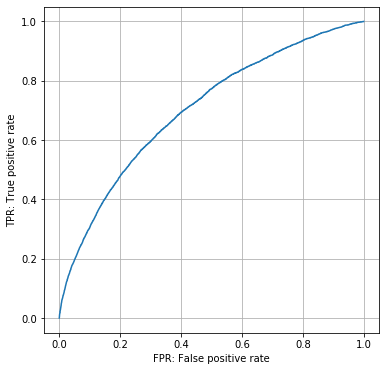

In [88]:
# プロット
roc = roc_curve(y4_valid, y4_valid_pred)
display(roc)

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 6)
plt.plot(roc[0], roc[1])
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

In [90]:
# test
## 特徴量取得
X4_test_df = credits_test[col_list].values
X4 = np.concatenate(
    (X4_test_df,
     credits_test['NAME_EDUCATION_TYPE'].replace(replace_dict).values.reshape(-1, 1),
     ratio_credit(credits_test),
     sum_req(credits_test)),
axis=1)
## 前処理
X4_test = scale_and_fill(X4, scaler)
## 予測・csv出力
out_pred_csv(credits_test, X4_test, rforest2, filename='sprint1-4.csv')

,SK_ID_CURR,TARGET
0,100001,0.038057
1,100005,0.079162
2,100013,0.017705
3,100028,0.051026
4,100038,0.101110
...,...,...
48739,456221,0.018750
48740,456222,0.082105
48741,456223,0.129247
48742,456224,0.016976


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int32  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 571.3 KB


True

# AUC
0.69386
# 考察
かなり精度が伸び、ハイパーパラメータチューニングの重要性を実感。

もう少し広い範囲での探索や特徴量の精査を行って精度を上げたい。

# 【問題5】
## 最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

# チューニング案
- `max_features`の調整
- `n_estimators`を1000くらいに増やしてみる

 -> どれもノートPCだとスペック不足？
- 線形回帰してみる？

In [107]:
# rforest2における特徴量の重要度を確認する
features = np.array([
    'EXT_SOURCE_1', 
    'EXT_SOURCE_2', 
    'EXT_SOURCE_3', 
    'DAYS_BIRTH', 
    'AMT_ANNUITY', 
    'DAYS_EMPLOYED',
    'NAME_EDUCATION_TYPE',
    'RATIO_CREDIT',
    'AMT_REQ_CREDIT_BUREAU'
]).reshape(-1, 1)
importances = rforest2.feature_importances_.reshape(-1, 1)

feat_imp = np.concatenate((importances, features), axis=1)
sorted_indexes = np.argsort(feat_imp[:, 0])

for i in sorted_indexes:
    print(feat_imp[i, :])

['0.014925704389284944' 'NAME_EDUCATION_TYPE']
['0.04385922706786155' 'AMT_REQ_CREDIT_BUREAU']
['0.1161024873873284' 'DAYS_EMPLOYED']
['0.12365618388391157' 'AMT_ANNUITY']
['0.12427638109467468' 'RATIO_CREDIT']
['0.13439359258140027' 'DAYS_BIRTH']
['0.13564473614390404' 'EXT_SOURCE_1']
['0.1438373501545799' 'EXT_SOURCE_3']
['0.16330433729705468' 'EXT_SOURCE_2']


'NAME_EDUCATION_TYPE'と'AMT_REQ_CREDIT_BUREAU'は重要度が低いため、削除する。

Kaggleのnotebookを参考に、'DAYS_ID_PBLISH', 'CODE_GENDER', 'DAYS_REGISTRATION', 'AMT_GOODS_PRICE'を代わりに追加してみる

In [111]:
new_feats_df = credits_train[['DAYS_ID_PUBLISH', 'CODE_GENDER', 'DAYS_REGISTRATION', 'AMT_GOODS_PRICE']]
display(new_feats_df)
# 値の調査 
print(new_feats_df.isnull().sum())
"""
CODE_GENDER: カテゴリ変数なのでダミー変数に変換する
AMT_GOODS_PRICE: 少し欠損値があるので、scale_and_fillを使ってみる
"""
print(new_feats_df['CODE_GENDER'].value_counts())

,DAYS_ID_PUBLISH,CODE_GENDER,DAYS_REGISTRATION,AMT_GOODS_PRICE
0,-2120,M,-3648.0,351000.0
1,-291,F,-1186.0,1129500.0
2,-2531,M,-4260.0,135000.0
3,-2437,F,-9833.0,297000.0
4,-3458,M,-4311.0,513000.0
...,...,...,...,...
307506,-1982,M,-8456.0,225000.0
307507,-4090,F,-4388.0,225000.0
307508,-5150,F,-6737.0,585000.0
307509,-931,F,-2562.0,319500.0


DAYS_ID_PUBLISH        0
CODE_GENDER            0
DAYS_REGISTRATION      0
AMT_GOODS_PRICE      278
dtype: int64
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64


In [122]:
# 少数のXNAを除いてダミー変換
def genders(df):
    arr_tmp = df['CODE_GENDER'].values
    male = np.where(arr_tmp == 'M', 1, 0).reshape(-1, 1)
    female = np.where(arr_tmp == 'F', 1, 0).reshape(-1, 1)
    return np.concatenate((male, female), axis=1)

In [123]:
print(genders(credits_train))

[[1 0]
 [0 1]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [130]:
# 特徴量の作成
col_list = [
    'EXT_SOURCE_1', 
    'EXT_SOURCE_2', 
    'EXT_SOURCE_3', 
    'DAYS_BIRTH', 
    'AMT_ANNUITY', 
    'DAYS_EMPLOYED',
    'DAYS_ID_PUBLISH', 
    'DAYS_REGISTRATION', 
    'AMT_GOODS_PRICE'
]
X5_tmp = credits_train[col_list].values
# 'CODE_GENDER'
gender_num = genders(credits_train)
# 'AMT_CREDIT':'AMT_TOTAL_INCOME'
ratio_credits_num = ratio_credit(credits_train)
X5 = np.concatenate((X5_tmp, ratio_credits_num), axis=1)

X5_train, X5_valid, gnum_train, gnum_valid, y5_train, y5_valid = train_test_split(X5, gender_num, y, stratify=y)

scaler.fit(X5_train)
X5_train_new = np.concatenate((scale_and_fill(X5_train, scaler), gnum_train), axis=1)
display(X5_train_new)

array([[ 0.6856338 ,  0.3843295 , -1.79967624, ...,  0.34145214,
         0.        ,  1.        ],
       [ 0.80492136, -0.01346336, -1.72210292, ...,  0.38908471,
         0.        ,  1.        ],
       [ 1.10025961, -0.09920044,  0.09590901, ...,  4.46833656,
         0.        ,  1.        ],
       ...,
       [-0.85728347, -0.2534717 , -0.242867  , ..., -0.0710083 ,
         1.        ,  0.        ],
       [ 0.35922689,  0.52449304, -0.98030492, ..., -0.4913575 ,
         0.        ,  1.        ],
       [ 1.15649349,  0.43565105, -0.45583212, ...,  1.15476227,
         0.        ,  1.        ]])

In [132]:
# グリッドサーチを行う
rforest5 = RandomForestClassifier()
params = {
    'n_estimators': [500, 1000],
    'max_features': [1, 'auto', None],
    'min_samples_split': [5, 10]
}
gscv = GridSearchCV(rforest5, param_grid=params, cv=5, verbose=1, n_jobs=-1)
gscv.fit(X5_train_new, y5_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 222.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [141]:
# 最適パラメータ確認
print(f'best score: {gscv.best_score_}')
print(f'best params: {gscv.best_params_}')

best score: nan
best params: {'max_features': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [134]:
# 最適パラメータでバリデーションを行う
X5_valid_new = np.concatenate((scale_and_fill(X5_valid, scaler), gnum_valid), axis=1)
best = gscv.best_estimator_
y5_valid_pred = best.predict_proba(X5_valid_new)[:, 1]

print(f'AUC: {roc_auc_score(y5_valid, y5_valid_pred)}')
print(best)

AUC: 0.7215922211453989
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


(array([0.        , 0.        , 0.        , ..., 0.9998585 , 0.99987265,
        1.        ]),
 array([0.00000000e+00, 1.61134386e-04, 6.44537544e-04, ...,
        9.99838866e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.59078066, 0.59078066, 0.56911429, ..., 0.00325   , 0.0032    ,
        0.0022    ]))

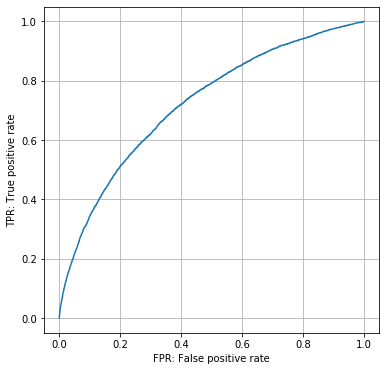

In [135]:
# プロット
roc = roc_curve(y5_valid, y5_valid_pred)
display(roc)

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 6)
plt.plot(roc[0], roc[1])
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

In [137]:
# テストデータに対して予測を行う
X5_test_tmp = credits_test[col_list].values
# 'CODE_GENDER'
gender_num_test = genders(credits_test)
# 'AMT_CREDIT':'AMT_TOTAL_INCOME'
ratio_credits_num_test = ratio_credit(credits_test)
X5_test = np.concatenate((X5_test_tmp, ratio_credits_num_test), axis=1)

X5_test_new = np.concatenate((scale_and_fill(X5_test, scaler), gender_num_test), axis=1)
display(X5_test_new)

# 予測/出力
out_pred_csv(credits_test, X5_test_new, best, filename='sprint1-5.csv')

array([[ 1.18831576,  1.4399033 , -1.80465068, ...,  0.09664746,
         0.        ,  1.        ],
       [ 0.29901603, -1.1629463 , -0.40147906, ..., -0.63313894,
         1.        ,  0.        ],
       [ 0.02250927,  0.97020009,  0.51208232, ..., -0.25203027,
         1.        ,  0.        ],
       ...,
       [ 1.09773367,  0.61992637, -1.16735615, ..., -0.89136088,
         0.        ,  1.        ],
       [-0.61055024, -0.35780957,  0.43236363, ..., -0.7261421 ,
         1.        ,  0.        ],
       [-0.73280075, -0.30115468, -1.22676982, ..., -0.60837415,
         0.        ,  1.        ]])

,SK_ID_CURR,TARGET
0,100001,0.110078
1,100005,0.096771
2,100013,0.035079
3,100028,0.036845
4,100038,0.102053
...,...,...
48739,456221,0.008500
48740,456222,0.066719
48741,456223,0.066879
48742,456224,0.060017


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int32  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 571.3 KB


True

In [139]:
# importance確認
features = np.array([
    'EXT_SOURCE_1', 
    'EXT_SOURCE_2', 
    'EXT_SOURCE_3', 
    'DAYS_BIRTH', 
    'AMT_ANNUITY', 
    'DAYS_EMPLOYED',
    'DAYS_ID_PUBLISH', 
    'DAYS_REGISTRATION', 
    'AMT_GOODS_PRICE',
    'RATIO_CREDIT',
    'MALE',
    'FEMALE'
]).reshape(-1, 1)
importances = best.feature_importances_.reshape(-1, 1)

feat_imp = np.concatenate((importances, features), axis=1)
sorted_indexes = np.argsort(feat_imp[:, 0])

for i in sorted_indexes:
    print(feat_imp[i, :])

['0.0026783658351924437' 'MALE']
['0.002751731962172453' 'FEMALE']
['0.07347874481323242' 'AMT_GOODS_PRICE']
['0.09007691961028175' 'DAYS_EMPLOYED']
['0.09395230436479192' 'AMT_ANNUITY']
['0.09546232387098978' 'RATIO_CREDIT']
['0.09780154568136407' 'DAYS_REGISTRATION']
['0.09843715794771656' 'DAYS_ID_PUBLISH']
['0.09991192046128672' 'DAYS_BIRTH']
['0.10166707471991748' 'EXT_SOURCE_1']
['0.11771962690263942' 'EXT_SOURCE_3']
['0.12606228383041493' 'EXT_SOURCE_2']


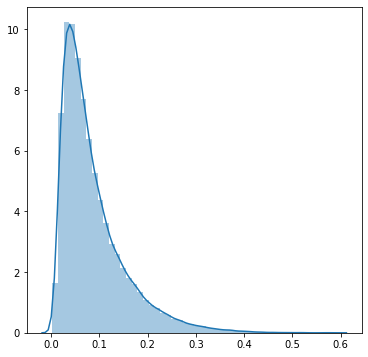

In [140]:
# バリデーションセットの予測結果の分布を見る
sns.distplot(y5_valid_pred)

# AUC
0.71593
# 考察
0.22ほどの精度の向上が見られた。
## 特徴量
新たに追加した特徴量についてはおおむね高めの重要度を示したが、性別に関してはほぼ結果に寄与していなかった。

参考にしたEDAを読み込んで特徴量のダミー変数化をどういった方針で行っているのか理解する必要がある。
## モデル
前回同様ランダムフォレストを使用した。

課題2で行ったハイパーパラメータ探索を参考に、max_featuresも加えてグリッドサーチを行ったが、max_features以外のパラメータに関しては課題2の結果と変化がなかった。n_estimatorsについては、多いほうが精度が出やすいという情報を目にしたため増やしたが今回はそれに反する結果となった。

60パターン（クロスバリデーション含む）でのグリッドサーチを行った結果、ローカル環境では4時間近くかかってしまった。課題2に比べ識別器数が多いことが影響していると考えられる。今後はクラウドリースの利用の検討、ランダムサーチの活用などを行う。

また、何故かグリッドサーチの最適スコアを算出することができなかった。正常に処理が行われていない可能性があるので調査が必要である。